In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import wisps.simulations as wispsim
import wisps
import splat
import splat.simulate as spsim
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.stats import kde

%matplotlib inline

In [2]:
def xyzr(d, v, theta):
    x=d*((1-v**2)**0.5)*np.cos(theta)
    y=d*((1-v**2)**0.5)*np.sin(theta)
    z=d*v
    r=(x**2+y**2)**0.5
    return x, y, z, r

def lnprob(direction, dmax, dmin):
    """
    probability density in all directions
    """
    d, cosb, l=direction
    if ((d>=dmax) or (d<=dmin)) or (abs(cosb) >=1) or ((l >=np.pi) or (l<=-np.pi)):
        return -np.inf
    else:
        x, y, z, r=xyzr(d, cosb, l)
        return np.log((d**3)*spsim.galactic_density_juric(r, z, unit='kpc', center='sun').value)
    
    
def sample_prob(dmax, dmin=0.0):
    ##sample the liliekhood function 
    ndim = 3
    nwalkers = 250
    p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(dmax, 0.0))
    sampler.run_mcmc(p0, 200)
    return sampler

def cdf(x):
    return kde.gaussian_kde(x).cdf

In [3]:
 ds, spgrid, vols=wispsim.compute_effective_volumes()

In [4]:
vols=np.array(vols)

In [5]:
directions=wispsim.OBSERVED_POINTINGS

In [6]:
directions.shape, vols.shape

((533,), (533, 18, 1))

In [7]:
def probability(l, b, dist=100*u.pc):
    new_coord=SkyCoord(l=l*u.radian, b=b*u.radian, distance=dist, frame='galactic')
    x, y, z=new_coord.galactic.cartesian.xyz
    r=(x**2+y**2)**0.5
    
    return np.log(dist**3*spsim.galactic_density_juric(r, z))

In [8]:
ls=np.linspace(-np.pi, np.pi, 100)
bs=np.linspace(-np.pi/2, np.pi/2, 100)
ds=np.logspace(-1, 6, 100)

In [9]:
probs=np.array([probability(l, b, dist=ds*u.pc) for l, b in zip(ls, bs)])

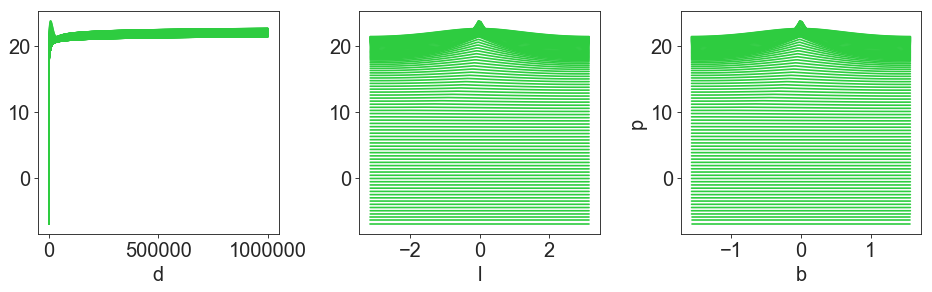

In [10]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 4))
p=ax[0].plot(ds, probs.T, color='#2ECC40')
ax[0].set_xlabel('d')

p=ax[1].plot(ls, probs, color='#2ECC40')
ax[1].set_xlabel('l')

p=ax[2].plot(bs, probs, color='#2ECC40')
ax[2].set_xlabel('b')

plt.ylabel('p')
#plt.yscale('log')

plt.tight_layout()

In [11]:
sampler=sample_prob(10**3, dmin=0.0)

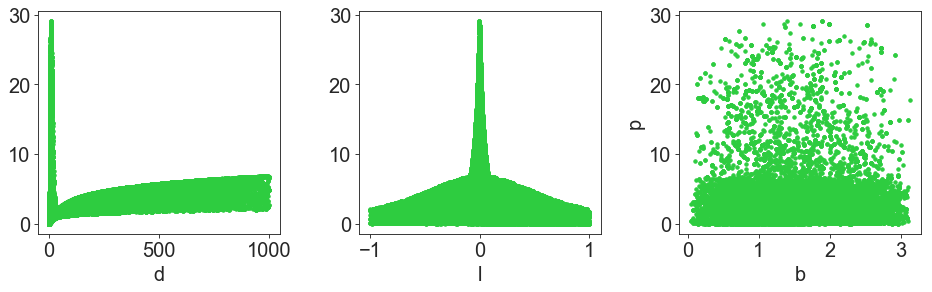

In [12]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 4))
p=ax[0].scatter(sampler.flatchain[:,0], np.concatenate(np.exp(sampler.lnprobability)), color='#2ECC40',  marker='.')
ax[0].set_xlabel('d')

p=ax[1].scatter(sampler.flatchain[:,1], np.concatenate(np.exp(sampler.lnprobability)), color='#2ECC40',  marker='.')
ax[1].set_xlabel('l')

p=ax[2].scatter(np.arccos(sampler.flatchain[:,2]), np.concatenate(np.exp(sampler.lnprobability)), color='#2ECC40', marker='.')
ax[2].set_xlabel('b')

plt.ylabel('p')
#plt.yscale('log')

plt.tight_layout()

In [19]:
x=sampler.flatchain[:,0]
#xgrid=np.logspace(np.log10(np.nanmin(x)), np.log10(np.nanmax(x)), 100)
xgrid=np.logspace(np.log10(np.nanmin(x)), np.log10(np.nanmax(x)), 100)

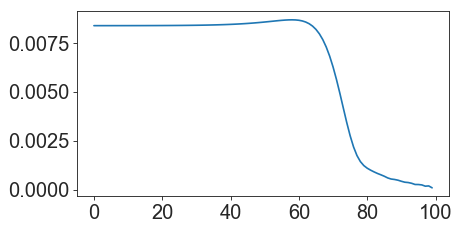

In [23]:
plt.plot(kde.gaussian_kde(x[~np.isnan(x)]).pdf(xgrid))

In [16]:
#